# Modèles de prédiction 

Je propose de résumer ici le travail d'exploration fait dans le premier notebook. 

L'objectif est de prédire deux variables numériques : la consommation d'énergie des bâtiments ```SiteEnergyUse(kBtu)```et la quantité d'émission de CO2 ```CO2_emissions```. Après différents pré-traitements tels que l'élimination des variables corrélées entres elles, ou la vectorisation des variables catégorielles, le jeu d'entrainement a la forme suivante : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model


In [2]:
data = pd.read_csv(res_path+"cleanned_data.csv", index_col=0)
print(len(data.columns[data.dtypes==float])-3, "training numerical variables")
print(len(data.columns[data.dtypes==int]), 
      "training interger variables (from tokenization of categorical variable)")
data.head()

6 training numerical variables
22 training interger variables (from tokenization of categorical variable)


,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),CO2_emissions,age_of_building,BuildingType_0,...,LargestPropertyUseType_2,LargestPropertyUseType_3,LargestPropertyUseType_4,LargestPropertyUseType_5,LargestPropertyUseType_6,LargestPropertyUseType_7,LargestPropertyUseType_8,LargestPropertyUseType_9,LargestPropertyUseType_10,LargestPropertyUseType_11
0,58091.0,1.0,12.0,0.0,88434.0,62.5,7103895.25,249.705,88.5,0,...,0,0,0,0,0,0,0,0,0,1
1,58091.0,1.0,11.0,15064.0,83880.0,56.0,8371084.00,279.685,19.5,0,...,0,0,0,0,0,0,0,0,0,1
2,58091.0,1.0,41.0,98359.0,756868.0,30.5,72858840.00,2075.380,46.5,0,...,0,0,0,0,0,0,0,0,0,1
3,58091.0,1.0,10.0,0.0,61320.0,28.5,17511952.00,1111.385,89.5,0,...,0,0,0,0,0,0,0,0,0,1
4,58848.5,1.0,18.0,37230.0,123445.0,71.0,14500852.50,506.355,35.5,0,...,0,0,0,0,0,0,0,0,0,1


# Mise à l'écart de l'ensemble de test : 
Je mets de côté l'ensemble de test, sur lequel je comparerai mes modèles prédictifs à la fin. 

### Séparation données d'entrainement

In [3]:
from sklearn.model_selection import train_test_split

X_original = data.drop(["SiteEnergyUse(kBtu)","CO2_emissions", "ENERGYSTARScore"], axis = 1)
y_original = data[["SiteEnergyUse(kBtu)","CO2_emissions"]]

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, train_size=0.8)

index_train = y_original_train.index
index_test = y_original_test.index

Par soucis de clarté de code, je vais renommer $X\_original\_train$ avec $X$. **Ainsi, le lecteur pourra bien comprendre que le $X$ évoqué dans la suite sera bien l'ensemble d'entrainement.**

In [4]:
X = X_original_train
y = y_original_train

### Standardisation entrainée sur l'ensemble d'entrainement

In [5]:
from sklearn import preprocessing
my_standardizer = preprocessing.StandardScaler()
my_standardizer.fit(X_original_train)

X_std = pd.DataFrame(my_standardizer.transform(X), columns=X.columns, index = X.index)
X_original_test_std = my_standardizer.transform(X_original_test)

## std y ?
my_standardizer.fit(y_original_train)

y_std = pd.DataFrame(my_standardizer.transform(y), columns = y.columns, index = y.index)
y_original_test_std = my_standardizer.transform(y_original_test)

# Régression Linéaire

for SiteEnergyUse(kBtu) in log space :


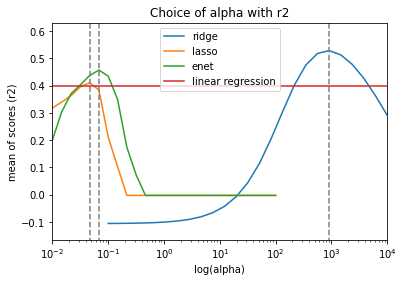

,score,execution_time,best_alpha
lr,0.4,0.020715,None
ridge,0.146277,0.332089,908.517576
lasso,0.099345,0.272646,0.046416
enet,0.126706,0.281547,0.068129


In [10]:
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                   "enet" : np.logspace(-2, 2, 25),
                  }

dict_models = {"ridge" : linear_model.Ridge(), 
               "lasso" : linear_model.Lasso(),
               "enet" : linear_model.ElasticNet(),
              }

var = "SiteEnergyUse(kBtu)"
X_ = X_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

for CO2_emissions in log space :


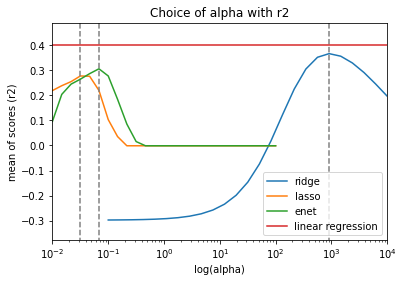

,score,execution_time,best_alpha
lr,0.4,0.009613,None
ridge,-0.028653,0.254808,908.517576
lasso,0.064107,0.306187,0.031623
enet,0.077806,0.197812,0.068129


In [11]:
var = "CO2_emissions"
X_ = X_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

La régression linéaire, même avec pénalisation, ne semble pas produire un modèle de prédiction convainquant, notamment à cause de la lourde queue de distribution des variables à prédire. Néansmoins, je vais utiliser la régression pénalisée lasso sur les variables "catégorielles" (issues de la vectorisation de ces dernière pour être précise), afin de voir si certaines de mes modalités sont non significatives (et peuvent donc être retirées).

for SiteEnergyUse(kBtu) in log space :


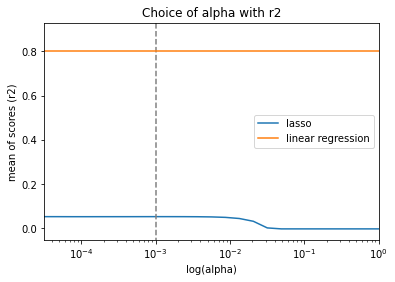

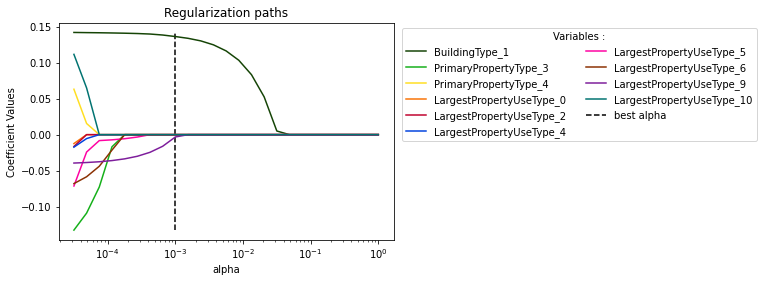

Modalities with zero coefficient in ANOVA :


Index(['BuildingType_1', 'LargestPropertyUseType_9'], dtype='object')

In [48]:
dict_param_grid["lasso"] = np.logspace(-4.5, 0, 25)

var = "SiteEnergyUse(kBtu)"
X_ = X.loc[:,X.dtypes == int]
y_ = np.log(y_std[var]+1)

print("for", var, "in log space :")
res = compare_regressions(X_, y_, {"lasso" : linear_model.Lasso(max_iter=10000)}, 
                          dict_param_grid, score_name="r2", fig_name=None)
plt.show()
## regul paths :
model_name = "lasso"
legend_kwargs = {"loc" : "upper right","bbox_to_anchor":(2.1, 1), "ncol":2}
plot_regul_paths(alpha_values = dict_param_grid[model_name], lm_model = dict_models[model_name], 
                 X_ = X_, y_ = y_, best_alpha=res.loc[model_name, "best_alpha"],
                 var_names = X_.columns, legend_kwargs=legend_kwargs)
plt.show()

model = dict_models[model_name]
model.set_params(alpha = res.loc[model_name, "best_alpha"])
model.fit(X_,y_)
models_coefs = model.coef_
print("Modalities with zero coefficient in ANOVA :")
zero_coeff_modality = X_.columns[[abs(coef) > 10**(-5) for coef in models_coefs]]
zero_coeff_modality

Je vais donc retirer ces méta-modalités, car elle n'ont pas d'influence dans cette ANOVA. 

In [45]:
X = X.drop(zero_coeff_modality.values, axis =1)

# Liste des modèles testés : 

## 1. Régression à noyaux 

Est-ce que le lien entre les données serait mieux représenté dans un RKHS ? 

In [50]:
from sklearn.kernel_ridge import KernelRidge

dict_models["kernel_ridge"] = KernelRidge()
dict_param_grid["kernel_ridge"] = np.logspace(-1, 4, 25)


## 2. KNN :

## 3. SVM : 

In [51]:
from sklearn.svm import SVR

dict_models["SVR"] = SVR(kernel = "linear")
dict_param_grid["SVR"] = np.logspace(-1, 4, 25)


Il faut que je modifie mon format de dict_param_grid pour qu'il devienne dictionnaire de dictionnaire (avec le nom des hyper-params et leur valeurs, pour chaque modèle

Dans [l'aide de la fonction SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), il y a une exemple d' utilisation de pipeline, à voir si ce n'est pas pertinent pour moi

## 4. Forêts aléatoires

# Résultats et interprétation : 